In [1]:
#Importing all the required libraries
import numpy as np
import pandas as pd
import os
import datetime
import glob
import warnings
import cv2
import shutil
warnings.filterwarnings("ignore")

In [2]:
#Importing the info related to the images
driver_details=pd.read_csv(r"Filtered_Dataset/driver_imgs_list.csv")
driver_details.shape

(22424, 3)

In [3]:
#Finding the wrong images in the dataset that are present inside the specific class folders irrespective of their representative
#behaviours
rm=[0,1,5,7,8,9]
rm_img=[]
for i in rm:
    for j in glob.glob("Filtered_Dataset/c"+str(i)+"_wrong/*.jpg"):
        rm_img.append(j.split("/")[2])

In [4]:
#Removing the images that are present in the folders irrespective of their representative behaviours
driver_details=driver_details[~driver_details["img"].isin(rm_img)]
driver_details.shape

(22234, 3)

In [5]:
#Printing a snippet of the driver_details remained after the removal of wrong images
driver_details.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
#Shape of driver_details dataframe representing the no of images to be dealt further
driver_details.shape

(22234, 3)

In [7]:
#Loading images seperately on Train, Val and Test dataframe based on the different ethnic groups
train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

train_df = driver_details.loc[~driver_details['subject'].isin(['p022','p072','p014','p050'])]
val_df =  driver_details.loc[driver_details['subject'].isin(['p014','p050'])]
test_df  = driver_details.loc[driver_details['subject'].isin(['p022','p072'])]

In [8]:
#Converting dataframe into list
train_list=train_df.values.tolist()
val_list=val_df.values.tolist()
test_list=test_df.values.tolist()

In [9]:
#Merging validation and test list and saving the same into temp list and printing the length of the same
temp = val_list+test_list
import random
random.seed(42)
random.shuffle(temp)
len(temp)

3223

In [10]:
#Dividing the temp list by half and appending the last half to the train list while storing the first half into the test list
#This has been done to make model aware of all types of ethic groups on which it is really going to test
random.shuffle(train_list)
train_list.extend(temp[:len(temp)//2])
test_list = temp[len(temp)//2:]

In [11]:
#Making 10 different class folders before splitting the test and train dataset
base_dir = 'Dataset/'
os.makedirs(base_dir, exist_ok=True)

base_dir1 = 'Dataset1/'
os.makedirs(base_dir1, exist_ok=True)

train_dir = os.path.join(base_dir1, 'train2')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir1, 'test2')
os.makedirs(test_dir, exist_ok=True)

for i in range(10):
    train_dir_all_class = os.path.join(train_dir, 'c'+str(i))
    os.makedirs(train_dir_all_class, exist_ok=True)
    
for i in range(10):
    test_dir_all_class = os.path.join(test_dir, 'c'+str(i))
    os.makedirs(test_dir_all_class, exist_ok=True)

In [12]:
#Copying the images to the train dataset
for image in train_list:
    shutil.copyfile(base_dir+image[1]+'/'+image[2], train_dir+'/'+image[1]+'/'+image[2])

In [15]:
#Copying the images to the test dataset
for image in test_list:
    shutil.copyfile(base_dir+image[1]+'/'+image[2], test_dir+'/'+image[1]+'/'+image[2])

In [16]:
#Importing ImageDataGenerator and preprocess_input for image augumentation purpose and creating a train data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
train_data_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1,
      preprocessing_function=preprocess_input,
      validation_split=0.1)

In [17]:
#Creating the train and val generator object
train_gen = train_data_generator.flow_from_directory(
        train_dir,
        target_size=(128,128),
        batch_size=64,
        class_mode='categorical',
        subset='training')

val_gen = train_data_generator.flow_from_directory(
        train_dir,
        target_size=(128,128),
        batch_size=64,
        class_mode='categorical',
        subset='validation')

Found 18565 images belonging to 10 classes.
Found 2057 images belonging to 10 classes.


In [18]:
#Setting batch size, epochs, number of training and validation sequences 
batch_size=64
num_train_sequences = train_gen.samples
print('# training sequences =', num_train_sequences)
num_val_sequences = val_gen.samples
print('# val sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 18565
# val sequences = 2057
# epochs = 15


In [19]:
#Importing tensorflow and keras libraries required for model building and training purpose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten,Dropout,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image 
from tensorflow.keras import optimizers
from tensorflow.keras.layers import concatenate, add, Input, BatchNormalization
from tensorflow.keras.models import Model

In [20]:
# Residual block implementation
def skip_block(layer_in, n_filters, n_conv):
    merge_input = layer_in
    # check if the number of filters needs to be increase in layer_in based in n_filters
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # adding convolutional layers to the model
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # adding batch normalization layer to the model
    layer_in = BatchNormalization()(layer_in)
    # adding ouputs saved in layer_in and merge_input, this will act as skip connection in skip_block module
    layer_in = add([layer_in, merge_input])
    # adding max pooling layer to the model
    layer_out = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_out

In [21]:
# Building the model
input_img = Input(shape=(128,128, 3))

layer = skip_block(input_img, 16, 3)
layer = skip_block(layer, 32, 3)
layer = skip_block(layer, 64, 3)
layer = skip_block(layer, 128, 3)
layer = skip_block(layer, 256, 3)

layer = GlobalAveragePooling2D()(layer)

layer = Flatten()(layer)

layer = Dense(256, activation='relu')(layer)
layer = Dropout(0.2)(layer)

layer = Dense(256, activation='relu')(layer)
layer = Dropout(0.2)(layer)

layer = Dense(128, activation='relu')(layer)

layer = BatchNormalization()(layer)

output = Dense(10, activation='softmax')(layer)

# summarize the model
model = Model(input_img,output)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_2[0][0]                   
_______________________________________________________________________________________

In [22]:
#setting optimizer as adam and them compiling the model
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_2[0][0]                   
_______________________________________________________________________________________

In [23]:
#Setting callback list using ReduceLROnPlateau, earlystopping and checkpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.002,
                                   cooldown=0,
                                   patience=3,
                                   min_lr=1e-4)
callbacks_list = [checkpoint, LR]

In [24]:
#Setting the size for steps per epoch and also the validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
#Model Generation
model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_gen, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
  2/291 [..............................] - ETA: 25s - loss: 3.0286 - categorical_accuracy: 0.0938

W1024 13:10:45.704719 139785193903936 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0676s vs `on_train_batch_end` time: 0.1080s). Check your callbacks.


291/291 [==============================] - ETA: 0s - loss: 2.0455 - categorical_accuracy: 0.2360
Epoch 00001: val_loss improved from inf to 3.03752, saving model to model_init_2020-10-2413_10_39.899492/model-00001-2.04551-0.23598-3.03752-0.11133.h5
291/291 [==============================] - 174s 597ms/step - loss: 2.0455 - categorical_accuracy: 0.2360 - val_loss: 3.0375 - val_categorical_accuracy: 0.1113
Epoch 2/15
291/291 [==============================] - ETA: 0s - loss: 1.2464 - categorical_accuracy: 0.5090
Epoch 00002: val_loss improved from 3.03752 to 1.38214, saving model to model_init_2020-10-2413_10_39.899492/model-00002-1.24644-0.50902-1.38214-0.47982.h5
291/291 [==============================] - 173s 596ms/step - loss: 1.2464 - categorical_accuracy: 0.5090 - val_loss: 1.3821 - val_categorical_accuracy: 0.4798
Epoch 3/15
291/291 [==============================] - ETA: 0s - loss: 0.6889 - categorical_accuracy: 0.7599
Epoch 00003: val_loss improved from 1.38214 to 1.08386, savin

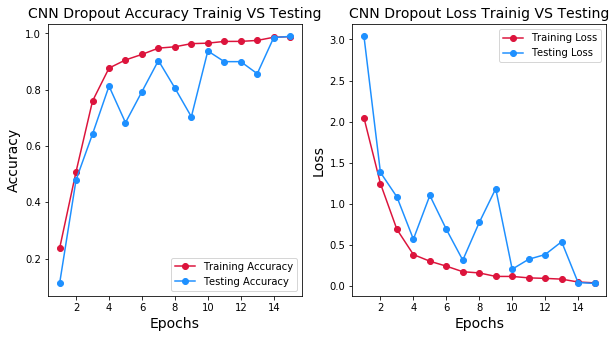

In [28]:
#Graphs between Accuracy vs epoch and loss vs epoch
from keras.callbacks import History as history
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['categorical_accuracy']) + 1), model.history.history['categorical_accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_categorical_accuracy']) + 1), model.history.history['val_categorical_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [29]:
#Setting up the testing generator and initilizing the object for the same
test_data_generator = ImageDataGenerator(rescale=1./ 255)
test_generator = test_data_generator.flow_from_directory(
        test_dir,
        target_size=(128,128),
        batch_size=64,
        class_mode='categorical',  
        shuffle=False
        )  
test_generator.reset()

Found 1612 images belonging to 10 classes.


In [30]:
#Prediction on the test dataset
Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)
print(sum(y_pred==classes)/test_generator.samples)

#Confusion Matrix on the Test Dataset
from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes[test_generator.index_array],y_pred)

0.9869727047146402


array([[208,   0,   0,   0,   2,   0,   0,   0,   0,   6],
       [  0, 184,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1, 174,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0, 164,   0,   0,   0,   0,   1,   2],
       [  0,   0,   0,   0, 183,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 158,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0, 176,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0, 115,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 101,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   5, 128]])